In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import cartopy
import cmocean as co
from matplotlib import pyplot as plt
import shapely
import cartopy.crs as ccrs
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.lines as mlines


import importlib
import sys

In [2]:
# path to some plotting routines
# sys.path.append(r'/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/src/')
sys.path.append(r'../../src/')

In [3]:
import visualization.plotTracksCartopy as myplots

In [4]:
# from dask.distributed import Client

In [5]:
# client = Client(n_workers=1, threads_per_worker=8, memory_limit=10e9)
# client

In [6]:
sns.set(style="whitegrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=8) #controls default text size
plt.rc('axes', titlesize=8) #fontsize of the title
plt.rc('axes', labelsize=8) #fontsize of the x and y labels
plt.rc('xtick', labelsize=8) #fontsize of the x tick labels
plt.rc('ytick', labelsize=8) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

In [7]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

data_path = "/data/spg_fresh_blob_202104_data/raw/"

interim_data_path = Path('data/interim/')

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

# output figures path
figure_path = Path("reports/figures/coldBlob/")

year = 1990

In [8]:
year_str = str(year)

In [9]:
# data_stores_subsets = list(sorted(Path(data_path).glob("*_????_subset.zarr/")))[:use_number_subset_years]
data_stores_subsets = list(sorted(Path(data_path).glob("*_"+year_str+"_subset_10percent.zarr/")))

In [10]:
display(data_stores_subsets)

[PosixPath('/data/spg_fresh_blob_202104_data/raw/tracks_randomvel_mxl_osnap_backward_1990_subset_10percent.zarr')]

In [11]:
ds_subsets = xr.concat(
    [xr.open_zarr(store) for store in data_stores_subsets],
    dim="traj",
)

display(ds_subsets)
print(ds_subsets.nbytes / 1e9, "GiB")

<xarray.Dataset>
Dimensions:  (obs: 731, traj: 516415)
Dimensions without coordinates: obs, traj
Data variables:
    lat      (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    lon      (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    mxl      (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    salt     (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    temp     (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    time     (traj, obs) datetime64[ns] dask.array<chunksize=(16138, 23), meta=np.ndarray>
    uvel     (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    vvel     (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    z        (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

15.0999746 GiB


## Extract data on osnap line (initialised positions)

In [12]:
ds_subsets_osnap = ds_subsets.isel(obs=0)

## Update some attributes

In [13]:
# ds_subsets_osnap['vol_trans_normal'] = 
ds_subsets_osnap.mxl.attrs = {'units':'m','long_name':'mixed layer depth'}
ds_subsets_osnap.salt.attrs = {'units':'PSU','long_name':'salinity'}
ds_subsets_osnap.temp.attrs = {'units':'degC','long_name':'temperature'}
ds_subsets_osnap.uvel.attrs = {'units':'degrees_east/second','long_name':'u velocity (raw)'}
ds_subsets_osnap.vvel.attrs = {'units':'degrees_north/second','long_name':'v velocity (raw)'}

## Flag tracks by source region and pathway

In [14]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected while they are in a selected area.
    '''
    # particles are selected if they pass through given area.
    position =  ((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                        
    return position > 0.0, position < 0

#### from Labrador sea or from Gulf Stream

In [15]:
# from labrador sea
ds_in1, ds_notin1 = apply_left_of_line(ds_subsets,-75,-40,40,65)
ds_in2, ds_notin2 = apply_left_of_line(ds_subsets,-100,-58.2,48,52)
ds_in3, ds_notin3 = apply_left_of_line(ds_subsets,-45,-45,60,70)
ds_lab_in = ds_in1*ds_in2*ds_in3
# from west of 60W, south of Flemish Cap (to test path from labrador sea)
ds_in1, ds_notin1 = apply_left_of_line(ds_subsets,-60,-60,33,63)
ds_in2, ds_notin2 = apply_left_of_line(ds_subsets,-58.2,-100,52,48)
ds_60w_in = ds_in1*ds_in2
# from gulf stream
ds_in1, ds_notin1 = apply_left_of_line(ds_subsets,-60,-100,33,33)
ds_in2, ds_notin2 = apply_left_of_line(ds_subsets,-44,-44,0,33)
ds_gst_in = ds_in1 * ds_in2

In [16]:
# check trajectory routes
LabCu = ds_lab_in.max("obs")
LC60W = ds_60w_in.max("obs")
GulfS = ds_gst_in.max("obs")

# check when lef lab sea,crossed 60w or gulf stream. defaults to zero
LabCu_exit_index = ds_lab_in.argmax(axis=1)
LC60W_exit_index = ds_60w_in.argmax(axis=1)
GulfS_exit_index = ds_gst_in.argmax(axis=1)

LabCu_exit_index = LabCu_exit_index.where(LabCu_exit_index > 0,len(ds_subsets.obs)-1)
LC60W_exit_index = LC60W_exit_index.where(LC60W_exit_index > 0,len(ds_subsets.obs)-1)
GulfS_exit_index = GulfS_exit_index.where(GulfS_exit_index > 0,len(ds_subsets.obs)-1)

In [17]:
# check if most recently left Lab Sea
LabCu_is_source = (LabCu_exit_index < GulfS_exit_index)
GulfS_is_source = (LabCu_exit_index > GulfS_exit_index)
LC60W_is_path = (LabCu_exit_index > LC60W_exit_index).where(LabCu_is_source,False)

In [18]:
LCdir_is_path = LabCu_is_source.where(LC60W_is_path==False,False)
other_is_source = (LabCu_is_source==False).where(GulfS_is_source == False,False)

flag particles on osnap line by origin

In [19]:
ds_subsets_osnap = ds_subsets_osnap.assign({'LabCu_is_source':LabCu_is_source})
ds_subsets_osnap = ds_subsets_osnap.assign({'LC60W_is_path':LC60W_is_path})
ds_subsets_osnap = ds_subsets_osnap.assign({'LCdir_is_path':LCdir_is_path})
ds_subsets_osnap = ds_subsets_osnap.assign({'GulfS_is_source':GulfS_is_source})
ds_subsets_osnap = ds_subsets_osnap.assign({'other_is_source':other_is_source})


flag by pathway for Labrador Current parcels

In [20]:
ds_subsets_osnap.LabCu_is_source.attrs = {'long_name':'flag from Labrador Current'}
ds_subsets_osnap.LC60W_is_path.attrs   = {'long_name':'flag from LC via 60W'}
ds_subsets_osnap.LCdir_is_path.attrs   = {'long_name':'flag from LC direct'}
ds_subsets_osnap.GulfS_is_source.attrs = {'long_name':'flag from Gulf Stream'}
ds_subsets_osnap.other_is_source.attrs = {'long_name':'flag source not found'}

## Find the 'obs' index of the point where parcel leaves the source region

### known source regions

In [21]:
# test individaul positions to see when the source was left
# defaults to zero if particular source was not on track
LabCu_exit_index = (ds_lab_in.where(ds_subsets_osnap.LabCu_is_source,False)).argmax(axis=1)
GulfS_exit_index = (ds_gst_in.where(ds_subsets_osnap.GulfS_is_source,False)).argmax(axis=1)

# combine in to one array. Nonzero numbers should not overlap for 
# Lab current and Gulf Stream
exit_index = LabCu_exit_index + GulfS_exit_index
# convert zeros to max dim obs
exit_index = exit_index.where(exit_index > 0,len(ds_subsets.obs)-1)

### index last non nan value for 'other' parcels

In [22]:
a = ds_subsets.lat  # just a random selection of variable, nans the same for all variables
b = (~np.isnan(a)).cumsum(dim='obs').argmax(dim='obs') # finds last non-nan in dim 'obs'. nicked from stackoverflow search
exit_index = xr.ufuncs.minimum(exit_index,b).compute()

### extract source positions from full array

In [23]:
ds_subsets_sourc = ds_subsets.isel(traj=xr.DataArray(range(len(ds_subsets.traj)),dims='traj'),obs=exit_index)

add the source and pathway flags to ds_subsets_sourc to match for xr.concat

In [24]:
# flag particles on osnap line by origin and pathway
ds_subsets_sourc = ds_subsets_sourc.assign({'LabCu_is_source':LabCu_is_source})
ds_subsets_sourc = ds_subsets_sourc.assign({'LC60W_is_path':LC60W_is_path})
ds_subsets_sourc = ds_subsets_sourc.assign({'LCdir_is_path':LCdir_is_path})
ds_subsets_sourc = ds_subsets_sourc.assign({'GulfS_is_source':GulfS_is_source})
ds_subsets_sourc = ds_subsets_sourc.assign({'other_is_source':other_is_source})


In [25]:
ds_subsets_sourc.LabCu_is_source.attrs = {'long_name':'flag from Labrador Current'}
ds_subsets_sourc.LC60W_is_path.attrs   = {'long_name':'flag from LC via 60W'}
ds_subsets_sourc.LCdir_is_path.attrs   = {'long_name':'flag from LC direct'}
ds_subsets_sourc.GulfS_is_source.attrs = {'long_name':'flag from Gulf Stream'}
ds_subsets_sourc.other_is_source.attrs = {'long_name':'flag source not found'}

### combine source and osnap positions and characteristics

In [26]:
ds_subsets_paths = xr.concat([ds_subsets_osnap,
                             ds_subsets_sourc],
                             dim='ends')

### flag particles entering from north from Greenland Sea or Davis Strait

In [27]:
b = b.compute()

In [28]:
ds_subsets_domexi = ds_subsets.isel(traj=xr.DataArray(range(len(ds_subsets.traj)),dims='traj'),obs=b)

In [29]:
# from Hudson Bay
ds_in1, ds_notin1 = apply_left_of_line(ds_subsets,-68,-68,33,63)
ds_in2, ds_notin2 = apply_left_of_line(ds_subsets,-95,-60,52,52)
ds_hud_in = ds_in1*ds_in2

HudBa = ds_hud_in.max("obs")


In [30]:
HudBa.data.compute()

array([False, False, False, ..., False, False, False])

In [31]:
# counts how many times enters or leaves lab sea
spgnoloop = (abs(ds_lab_in.astype(int).diff(dim='obs')).sum(dim='obs')<3).compute()

In [32]:
Green_is_source = (ds_subsets_paths.isel(ends=0).LabCu_is_source &
                  (ds_subsets_domexi.lat > 65) & 
                  (ds_subsets_domexi.lon > -44) &
                  spgnoloop)
Davis_is_source = (ds_subsets_paths.isel(ends=0).LabCu_is_source &
                  (ds_subsets_domexi.lat > 65) & 
                  (ds_subsets_domexi.lon < -44) &
                  spgnoloop)
Hudba_is_source = (ds_subsets_paths.isel(ends=0).LabCu_is_source & 
                  HudBa &
                  spgnoloop)

In [33]:
Green_is_source = xr.concat([(Green_is_source),(Green_is_source)],dim='ends')
ds_subsets_paths = ds_subsets_paths.assign({'Green_is_source':Green_is_source})
Davis_is_source = xr.concat([(Davis_is_source),(Davis_is_source)],dim='ends')
ds_subsets_paths = ds_subsets_paths.assign({'Davis_is_source':Davis_is_source})
Hudba_is_source = xr.concat([(Hudba_is_source),(Hudba_is_source)],dim='ends')
ds_subsets_paths = ds_subsets_paths.assign({'Hudba_is_source':Hudba_is_source})


add the source and pathway flags to ds_subsets_sourc to match for xr.concat

In [34]:
ds_subsets_paths.Davis_is_source.attrs = {'long_name':'flag from Davis Strait'}
ds_subsets_paths.Green_is_source.attrs = {'long_name':'flag from Greenland Sea'}
ds_subsets_paths.Hudba_is_source.attrs = {'long_name':'flag from Hudson Bay'}


## We want to test for tracks which route north of osnap line between source and final times

This is because a common strategy is to remove these from analysis and only consider the 'direct' paths.

### Test particle positions

### section position data

In [35]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

#### south/north of osnap-e

In [36]:
# do north and south separately because of missing values

south = xr.Dataset()
north = xr.Dataset()
epsilon = 0.05
for i in range(len(lonlat.lon)-1):
    south['subsect'+str(i)],north['subsect'+str(i)] = apply_left_of_line(ds_subsets,lonlat.lon[i+1],lonlat.lon[i],lonlat.lat[i+1]+epsilon,lonlat.lat[i]+epsilon)

# check in osnap east 
south_oe,north_oe = apply_left_of_line(ds_subsets,-44,-44,30,60)

# south_a = south.subsect0 + south.subsect1 + south.subsect2 
# south_b = south.subsect3 * south.subsect4 * south.subsect5
south_b = south.subsect4 * south.subsect5
south_c = south.subsect6 + south.subsect7 + south.subsect8 
south_d = south.subsect8 * south.subsect9 * south.subsect10 * south.subsect11 
# south_e = south.subsect12
# south_all = south_a * south_c * south_e * (south_b + south_d)
south_all = south_oe + (south_c * (south_b + south_d))

# north_a = north.subsect0 * north.subsect1 * north.subsect2 
# north_b = north.subsect3 + north.subsect4 + north.subsect5
north_b = north.subsect4 + north.subsect5
north_c = north.subsect6 * north.subsect7 * north.subsect8 
north_d = north.subsect8 + north.subsect9 + north.subsect10 + north.subsect11
# north_e = north.subsect12
# north_all = north_a + north_c + north_e + (north_b * north_d)
north_all = north_oe * (north_c  + (north_b * north_d))


In [37]:
north_all = north_all.reset_coords(drop=True)
south_all = south_all.reset_coords(drop=True)

In [38]:
# test individual positions to see when the parcel was first (in 'obs', last in time) north of osnap line
# defaults to zero if particular source was not on track
north_osnap_index = (north_all).argmax(axis=1)
# convert zeros to max dim obs
north_osnap_index = north_osnap_index.where(north_osnap_index > 0,len(ds_subsets.obs)-1)

Check if found north of osnap e between leaving source and arriving at osnap and flag to ds_subsets_paths

In [39]:
north_osnap = xr.concat([(north_osnap_index < exit_index),(north_osnap_index < exit_index)],dim='ends')
ds_subsets_paths = ds_subsets_paths.assign({'north_of_osnap':north_osnap})
ds_subsets_paths.north_of_osnap.attrs = {'long_name':'flag path goes north of osnap-e'}
display(ds_subsets_paths)

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 516415)
Dimensions without coordinates: ends, traj
Data variables: (12/18)
    lat              (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    lon              (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    mxl              (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    salt             (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    temp             (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    time             (ends, traj) datetime64[ns] dask.array<chunksize=(1, 16138), meta=np.ndarray>
    ...               ...
    GulfS_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    other_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    Green_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    Davis_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    Hudba_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    north_of_osnap   (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [42]:
ds_subsets.isel(obs=0)

<xarray.Dataset>
Dimensions:  (traj: 516415)
Dimensions without coordinates: traj
Data variables:
    lat      (traj) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
    lon      (traj) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
    mxl      (traj) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
    salt     (traj) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
    temp     (traj) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
    time     (traj) datetime64[ns] dask.array<chunksize=(16138,), meta=np.ndarray>
    uvel     (traj) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
    vvel     (traj) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
    z        (traj) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [40]:
lonRange=[-37,0]
depthRange=[0,500]


In [44]:
ds_select = ds_subsets.where((ds_subsets.isel(obs=0).lon > lonRange[0]) & (ds_subsets.isel(obs=0).lon < lonRange[1]))
ds_select = ds_select.where((ds_subsets.isel(obs=0).z > depthRange[0]) & (ds_subsets.isel(obs=0).z < depthRange[1]))
ds_select = ds_select.where((ds_subsets_paths.isel(ends=0).north_of_osnap == False))

In [45]:
# ds_select=ds_select.where((ds_subsets_paths.isel(ends=0).LabCu_is_source))
# ds_select=ds_select.where((ds_subsets_domexi.lat > 65) & (ds_subsets_domexi.lon < -44))
# ds_select=ds_select.where((ds_subsets_paths.isel(ends=0).No_spg_loops))

# ds_select_plot=ds_select.where((ds_subsets_paths.isel(ends=0).LabCu_is_source))
# ds_select=ds_select.where((ds_subsets_paths.isel(ends=0).Green_is_source))


In [46]:
# ds_select_plot = ds_select_plot.dropna(dim='traj',how='all')

In [47]:
display(ds_select)
ds_select.lon.shape[0]

<xarray.Dataset>
Dimensions:  (obs: 731, traj: 516415)
Dimensions without coordinates: obs, traj
Data variables:
    lat      (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    lon      (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    mxl      (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    salt     (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    temp     (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    time     (traj, obs) datetime64[ns] dask.array<chunksize=(6000, 23), meta=np.ndarray>
    uvel     (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    vvel     (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
    z        (traj, obs) float32 dask.array<chunksize=(6000, 731), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

516415

In [48]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

def plotTracksCartopy_local(ds0,ds1,ds_paths,title='',figname=''):
    
    central_lon, central_lat = -45, 47.5
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")

    
#     fig, ax = plt.subplots(figsize = (12,8),dpi=200,
#                            subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
    fig, ax = plt.subplots(figsize = (12,8),dpi=200,
                           subplot_kw={'projection': ccrs.Mercator(central_longitude=-45.0, 
                                                                   min_latitude=24.0, 
                                                                   max_latitude=70.0, 
                                                                   globe=None, 
                                                                   latitude_true_scale=0.0)})
    gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=False)
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlocator = mticker.FixedLocator([-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20])
    ax.coastlines(resolution='50m')
    
    dsmask = ds1
    for i in range(dsmask.lon.shape[0]):
        if ds_paths.isel(ends=0,traj=i).LabCu_is_source:
            if ds_paths.isel(ends=0,traj=i).LC60W_is_path:
                color='C4'
                linewidth=1.5
            else:
                color='C9'
                linewidth=1.5
        elif ds_paths.isel(ends=0,traj=i).GulfS_is_source:
            if (i % 2 == 0):
                color='C2'
                linewidth=1.5
            else:
                color='C2'
                linewidth=0
        else:
            color='C3'
            linewidth=1.5
        pcm = ax.plot(
            dsmask.lon.isel(traj=i).data,
            dsmask.lat.isel(traj=i).data,zorder=5,color=color,linewidth=linewidth,
            transform=ccrs.PlateCarree())

    ax.scatter(
        ds0.lon.data.flatten(),
        ds0.lat.data.flatten(),3,zorder=10,color='k',
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-58.2,-45,num=20),np.linspace(52,61.428571,num=20),
        zorder=5,color='C1',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-100,-58.2,num=20),np.linspace(48,52,num=20),
        zorder=5,color='C1',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-45,-45,num=20),np.linspace(61.428571,70,num=20),
        zorder=5,color='C1',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-60,-60,num=20),np.linspace(51.8,33,num=20),
        zorder=5,color='C4',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )

    ax.plot(np.linspace(-44,-100,num=20),np.linspace(33,33,num=20),
        zorder=5,color='C2',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-44,-44,num=20),np.linspace(0,33,num=20),
        zorder=5,color='C2',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    
    title=ax.set_title(title)

    gulfs_line = mlines.Line2D([], [], color='C2',label='Gulf Stream')
    lcdir_line = mlines.Line2D([], [], color='C9',label='Lab Sea direct path')
    other_line = mlines.Line2D([], [], color='C3',label='Other')
    lc60w_line = mlines.Line2D([], [], color='C4',label='Lab Sea 60$\degree$W path')
    ax.legend(handles=[lc60w_line,lcdir_line,gulfs_line,other_line])
   
#     plt.tight_layout()
    fignamepng = figname + '.png'
    plt.savefig(project_path / figure_path / fignamepng,dpi=300, bbox_inches='tight')

    return


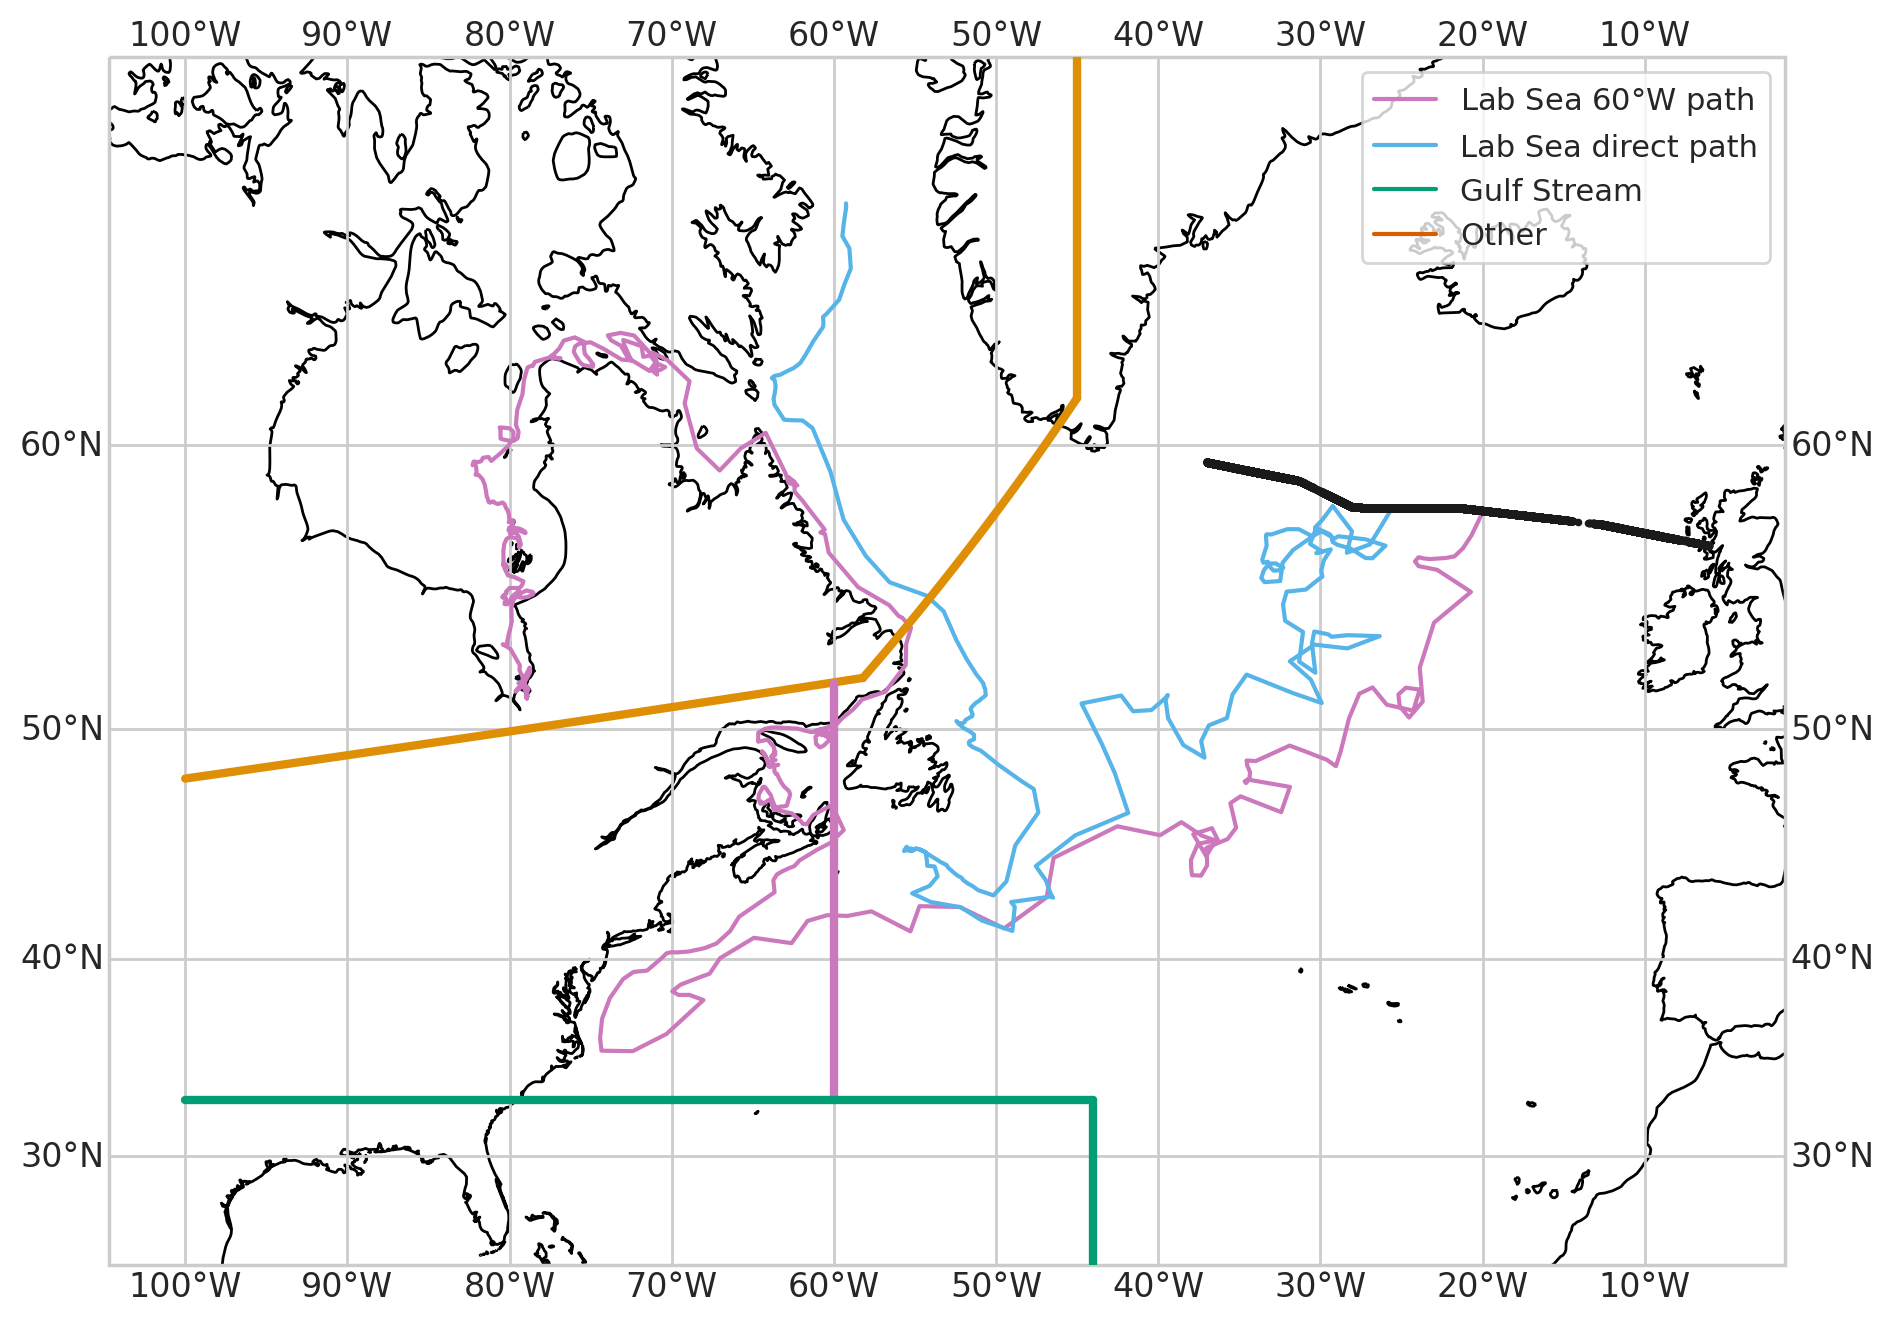

In [49]:

plotTracksCartopy_local(ds_select.isel(obs=0),
                        ds_select.isel(traj=slice(1,-1,40000)),
                        ds_subsets_paths.isel(traj=slice(1,-1,40000)),figname='particle_paths')

In [50]:
ds_select_plot=ds_select.where((ds_subsets_paths.isel(ends=0).LabCu_is_source))


In [51]:
display(ds_subsets_paths)
ds_select.lon.shape[0]

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 516415)
Dimensions without coordinates: ends, traj
Data variables: (12/18)
    lat              (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    lon              (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    mxl              (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    salt             (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    temp             (ends, traj) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    time             (ends, traj) datetime64[ns] dask.array<chunksize=(1, 16138), meta=np.ndarray>
    ...               ...
    GulfS_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    other_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    Green_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    Davis_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    Hudba_is_source  (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
    north_of_osnap   (ends, traj) bool dask.array<chunksize=(1, 6000), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

516415

In [52]:
def plotTracksCartopy_local(ds0,ds1,ds_paths,title='',figname=''):
    
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")

    
#     fig, ax = plt.subplots(figsize = (12,8),dpi=200,
#                            subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
    fig, ax = plt.subplots(figsize = (12,8),dpi=200,
                           subplot_kw={'projection': ccrs.Mercator(central_longitude=-45.0, 
                                                                   min_latitude=24.0, 
                                                                   max_latitude=70.0, 
                                                                   globe=None, 
                                                                   latitude_true_scale=0.0)})
    gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=False)
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlocator = mticker.FixedLocator([-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20])
    ax.coastlines(resolution='50m')
    
    dsmask = ds1
    for i in range(dsmask.lon.shape[0]):
        if ds_paths.isel(ends=0,traj=i).LabCu_is_source:
            if ds_paths.isel(ends=0,traj=i).Hudba_is_source:
                color='C8'
                linewidth=1.5
            elif ds_paths.isel(ends=0,traj=i).Davis_is_source:
                color='C6'
                linewidth=1.5
            elif ds_paths.isel(ends=0,traj=i).Green_is_source:
                color='C7'
                linewidth=1.5
            else:
                color='C5'
                linewidth=1.5
        else:
            color='C3'
            linewidth=0
            
        pcm = ax.plot(
            dsmask.lon.isel(traj=i).data,
            dsmask.lat.isel(traj=i).data,zorder=5,color=color,linewidth=linewidth,
            transform=ccrs.PlateCarree())

    ax.scatter(
        ds0.lon.data.flatten(),
        ds0.lat.data.flatten(),3,zorder=10,color='k',
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-58.2,-45,num=20),np.linspace(52,61.428571,num=20),
        zorder=5,color='C1',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-100,-58.2,num=20),np.linspace(48,52,num=20),
        zorder=5,color='C1',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-45,-45,num=20),np.linspace(61.428571,70,num=20),
        zorder=5,color='C1',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-60,-60,num=20),np.linspace(51.8,33,num=20),
        zorder=5,color='C4',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )

    ax.plot(np.linspace(-44,-100,num=20),np.linspace(33,33,num=20),
        zorder=5,color='C2',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-44,-44,num=20),np.linspace(0,33,num=20),
        zorder=5,color='C2',
        linewidth=3,
        transform=ccrs.PlateCarree()
    )
    
    title=ax.set_title(title)

    gulfs_line = mlines.Line2D([], [], color='C8',label='Hudson Bay')
    lcdir_line = mlines.Line2D([], [], color='C6',label='Davis Strait')
    other_line = mlines.Line2D([], [], color='C7',label='Greenland Sea')
    lc60w_line = mlines.Line2D([], [], color='C5',label='Subpolar Gyre')
    ax.legend(handles=[lc60w_line,lcdir_line,gulfs_line,other_line])
   
#     plt.tight_layout()
    fignamepng = figname + '.png'
    plt.savefig(project_path / figure_path / fignamepng,dpi=300, bbox_inches='tight')

    return


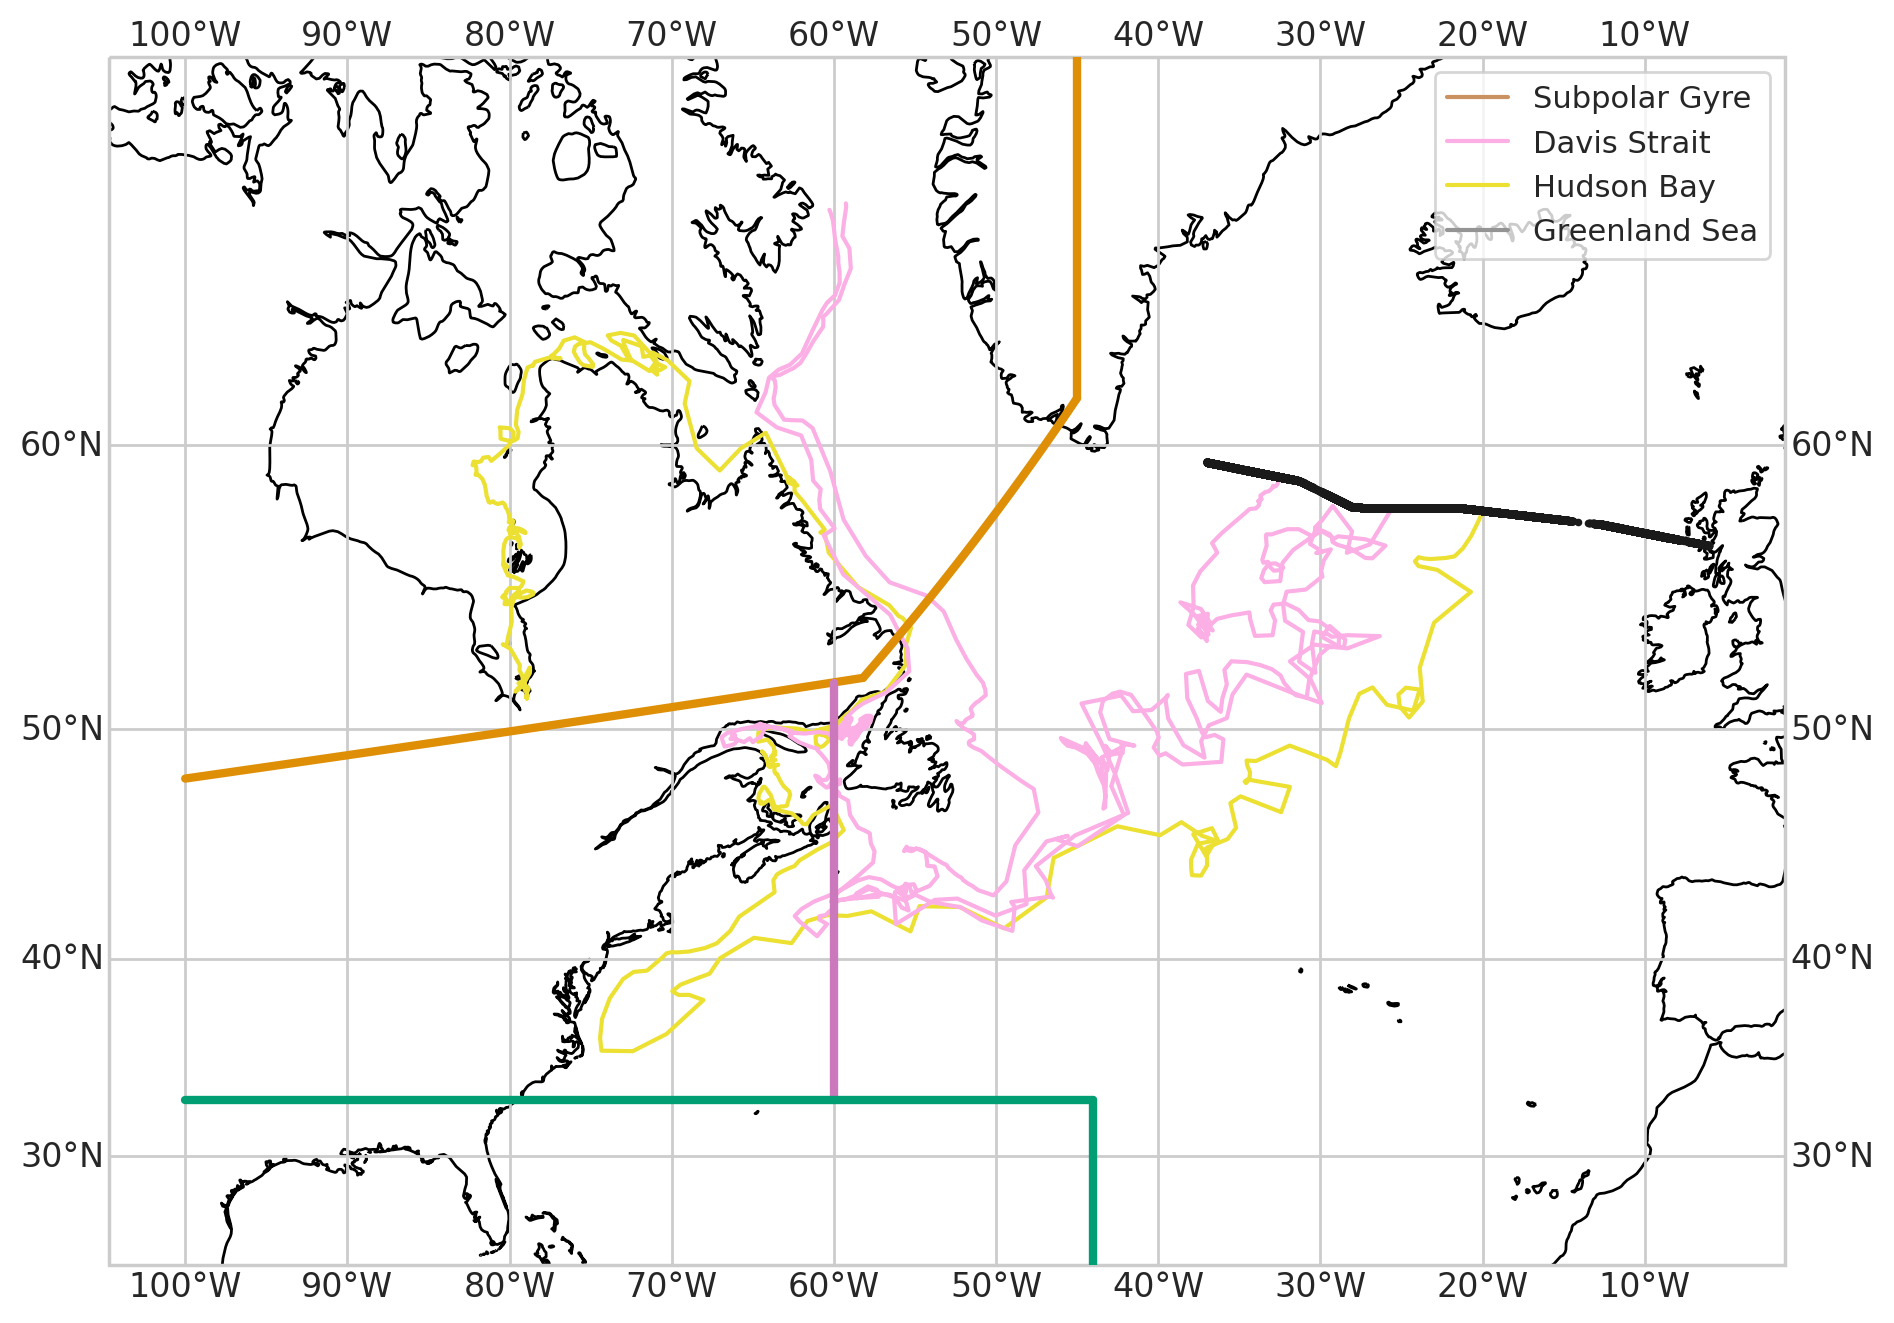

In [53]:
plotTracksCartopy_local(ds_select.isel(obs=0),
                        ds_select_plot.isel(traj=slice(1,-1,20000)),
                        ds_subsets_paths.isel(traj=slice(1,-1,20000)),figname='particle_source_lc')

In [77]:

def plotTracksCartopy_multi(ds0,ds1,ds_paths,title='',figname=''):
    
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")

    
#     fig, ax = plt.subplots(figsize = (12,8),dpi=200,
#                            subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
    fig, axes = plt.subplots(3,3,figsize = (12,9),
                           subplot_kw={'projection': ccrs.Mercator(central_longitude=-45.0, 
                                                                   min_latitude=24.0, 
                                                                   max_latitude=70.0, 
                                                                   globe=None, 
                                                                   latitude_true_scale=0.0)},
                            gridspec_kw={'hspace':0.05,'wspace':0.05})
#     gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=False)
#     gl.ylocator = LatitudeLocator()
#     gl.xformatter = LongitudeFormatter()
#     gl.yformatter = LatitudeFormatter()
#     gl.xlocator = mticker.FixedLocator([-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20])
#     ax.coastlines(resolution='110m')

    for j,ax in enumerate(axes.flatten()):
        gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=False)
        gl.ylocator = LatitudeLocator()
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
#         gl.xlocator = mticker.FixedLocator([-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20])
        ax.coastlines(resolution='110m')
        
        if j==0:
            dsmask=ds1.where(ds_paths.isel(ends=0).LabCu_is_source)
            color='C1'
            linewidth = 1.5
            gl.xlabels_bottom = False
            gl.ylabels_right = False
            ax.text(-99.9,66,'(a)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'All Lab Sea',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        elif j==1:
            dsmask=ds1.where(ds_paths.isel(ends=0).GulfS_is_source)
            color='C2'
            linewidth = 1.5
            gl.ylabels_right = False
            gl.xlabels_bottom = False
            gl.ylabels_left = False
            ax.text(-99.9,66,'(b)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'Gulf Stream',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        elif j==2:
            dsmask=ds1.where(ds_paths.isel(ends=0).other_is_source)
            color='C7'
            linewidth = 1.5
            gl.xlabels_bottom = False
            gl.ylabels_left = False
            ax.text(-99.9,66,'(c)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'other',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        elif j==3:
            dsmask=ds1.where(ds_paths.isel(ends=0).LCdir_is_path)
            color='C0'
            linewidth = 1.5
            gl.xlabels_top = False
            gl.ylabels_right = False
            gl.xlabels_bottom = False
            ax.text(-99.9,66,'(d)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'Direct path',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        elif j==4:
            dsmask=ds1.where(ds_paths.isel(ends=0).LC60W_is_path)
            color='C3'
            linewidth = 1.5
            gl.xlabels_top = False
            gl.ylabels_right = False
            gl.xlabels_bottom = False
            gl.ylabels_left = False
            ax.text(-99.9,66,'(e)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'Loop path',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        elif j==5:
            dsmask=ds1.where(ds_paths.isel(ends=0).Hudba_is_source)
            color='C6'
            linewidth = 1.5
            gl.xlabels_top = False
            gl.ylabels_left = False
            gl.xlabels_bottom = False
            ax.text(-99.9,66,'(f)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'Hudson Bay',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        elif j==6:
            dsmask=ds1.where(ds_paths.isel(ends=0).Davis_is_source)
            color='C5'
            linewidth = 1.5
            gl.xlabels_top = False
            gl.ylabels_right = False
            ax.text(-99.9,66,'(g)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'Davis Strait',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        elif j==7:
            dsmask=ds1.where(ds_paths.isel(ends=0).Green_is_source)
            color='C8'
            linewidth = 1.5
            gl.xlabels_top = False
            gl.ylabels_right = False
            gl.ylabels_left = False
            ax.text(-99.9,66,'(h)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'Greenland\nSea',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        elif j==8:
            dsmask=ds1.where((ds_paths.isel(ends=0).LabCu_is_source)*
                             (ds_paths.isel(ends=0).Hudba_is_source==False)*
                             (ds_paths.isel(ends=0).Davis_is_source==False)*
                             (ds_paths.isel(ends=0).Green_is_source==False)
                            )
            color='C9'
            linewidth = 1.5
            gl.xlabels_top = False
            gl.ylabels_left = False
            ax.text(-99.9,66,'(i)',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=1.0))
            ax.text(-42,27,'SPG',transform=ccrs.PlateCarree(),fontsize=14,zorder=10,bbox=dict(facecolor='w', alpha=0.7))
        

        for i in range(dsmask.lon.shape[0]):
            pcm = ax.plot(
                dsmask.lon.isel(traj=i).data,
                dsmask.lat.isel(traj=i).data,zorder=5,color=color,linewidth=linewidth,
                transform=ccrs.PlateCarree())
        ax.scatter(
            ds0.lon.data.flatten(),
            ds0.lat.data.flatten(),2,zorder=10,color='k',
            transform=ccrs.PlateCarree()
        )
# plot test lines for pathways
        ax.plot(np.linspace(-58.2,-45,num=20),np.linspace(52,61.428571,num=20),
            zorder=8,color='C1',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )
        ax.plot(np.linspace(-100,-58.2,num=20),np.linspace(48,52,num=20),
            zorder=8,color='C1',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )
        ax.plot(np.linspace(-45,-45,num=20),np.linspace(61.428571,70,num=20),
            zorder=8,color='C1',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )
        ax.plot(np.linspace(-60,-60,num=20),np.linspace(51.8,33,num=20),
            zorder=8,color='C3',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )

        ax.plot(np.linspace(-44,-100,num=20),np.linspace(33,33,num=20),
            zorder=8,color='C2',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )
        ax.plot(np.linspace(-44,-44,num=20),np.linspace(0,33,num=20),
            zorder=8,color='C2',
            linewidth=2,
            transform=ccrs.PlateCarree()
        )

# put a drk background beyind        
        ax.plot(np.linspace(-58.2,-45,num=20),np.linspace(52,61.428571,num=20),
            zorder=7,color='w',
            linewidth=3,
            transform=ccrs.PlateCarree()
        )
        ax.plot(np.linspace(-100,-58.2,num=20),np.linspace(48,52,num=20),
            zorder=7,color='w',
            linewidth=3,
            transform=ccrs.PlateCarree()
        )
        ax.plot(np.linspace(-45,-45,num=20),np.linspace(61.428571,70,num=20),
            zorder=7,color='w',
            linewidth=3,
            transform=ccrs.PlateCarree()
        )
        ax.plot(np.linspace(-60,-60,num=20),np.linspace(51.8,33,num=20),
            zorder=7,color='w',
            linewidth=3,
            transform=ccrs.PlateCarree()
        )

        ax.plot(np.linspace(-44,-100,num=20),np.linspace(33,33,num=20),
            zorder=7,color='w',
            linewidth=3,
            transform=ccrs.PlateCarree()
        )
        ax.plot(np.linspace(-44,-44,num=20),np.linspace(0,33,num=20),
            zorder=7,color='w',
            linewidth=3,
            transform=ccrs.PlateCarree()
        )
#         plotTracks(fig,axis)
    
    
    plt.tight_layout()
    fignamepng = figname + '.png'
    plt.savefig(project_path / figure_path / fignamepng,dpi=300, bbox_inches='tight')

    return


In [76]:
ds_paths=ds_subsets_paths.isel(traj=slice(1,-1,4000)).compute()
ds1=ds_select.isel(traj=slice(1,-1,4000)).compute()


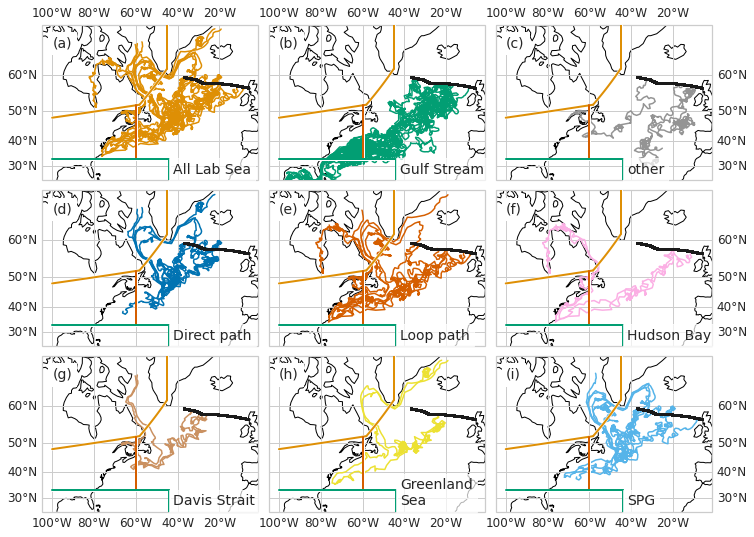

In [78]:
plotTracksCartopy_multi(ds_select.isel(obs=0),
                        ds1,
                        ds_paths,figname='particle_sources_and_pathways')

In [ ]:
conda list